 # Python Practice for ProMP (reproduction)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

#################################################<br>
Load the training data<br>
#################################################

In [14]:
mat = loadmat('../2Dletters/A.mat')
demosNum = 5 # number of demonstrations
dt = 0.005 # time interval
dataset = []
for i in range(demosNum):
    pos = mat['demos'][0, i]['pos'][0, 0]
    vel = np.gradient(pos, axis=-1) / dt
    pv = np.block([[pos], [vel]])
    dataset.append(pv)

#################################################<br>
Define variables and set parameters for ProMP<br>
#################################################

In [15]:
dim = 2  # 2D trajectory
Dim = 2 * dim # both position and velocity
len = dataset[0].shape[1] # length of demonstrations
tau = dt * len # motion duration
t0 = np.linspace(dt, tau, num=len)
center = np.linspace(0, 1, 20) # centers of basis functions
basisNum = center.shape[0] # number of basis functions
width = 50 # width of basis functions
lb1 = 1
lb2 = 10

#################################################<br>
Define basis functions<br>
#################################################

In [16]:
def BasisFunction(t):
    Phi_1 = np.zeros(basisNum)
    addsum = 0
    for b in range(basisNum):
        Phi_1[b] = np.exp(-width * (t / tau - center[b]) ** 2)
        addsum = addsum + Phi_1[b]
    Phi_1 = Phi_1 / addsum
    Phi_2 = np.zeros(basisNum)
    addsum = 0
    for b in range(basisNum):
        Phi_2[b] = np.exp(-width * ((t + dt) / tau - center[b]) ** 2)
        addsum = addsum + Phi_2[b]
    Phi_2 = Phi_2 / addsum
    Phi_2 = (Phi_2 - Phi_1)/dt
    Phi_extend = np.zeros((Dim, basisNum*dim))
    for i in range(dim):
        Phi_extend[i, i*basisNum:(i+1)*basisNum] = Phi_1
    for i in range(dim):
        Phi_extend[dim+i, i * basisNum:(i+1)*basisNum] = Phi_2
    return Phi_extend

###############################################################<br>
Estimate the distribution of the trajectory parameter vector w<br>
###############################################################

In [17]:
Phi = np.zeros((Dim*len, basisNum*dim))
weights = np.zeros((demosNum, basisNum*dim))
mu_w = np.zeros(basisNum*dim)
cov_w = np.zeros((basisNum*dim, basisNum*dim))

In [18]:
for i in range(len):
    Phi[i*Dim:(i+1)*Dim, :] = BasisFunction(t0[i])
PhiT_Phi = np.matmul(np.transpose(Phi), Phi) + lb1 * np.eye(basisNum*dim)
cw = np.matmul(np.linalg.pinv(PhiT_Phi), np.transpose(Phi))

In [19]:
# Estimate the trajectory parameter vector w from each demonstration
for i in range(demosNum):
    expandedTraj = dataset[i].flatten(order='F')
    weights[i, :] = np.matmul(cw, expandedTraj)

In [20]:
# Calculate the mean and covariance of w
mu_w = np.mean(weights, axis=0)
cov_w = np.matmul(np.transpose(weights - mu_w), weights - mu_w) / demosNum + lb2 * np.eye(basisNum*dim)

#################################################<br>
Prediction using ProMP<br>
#################################################

In [21]:
pred_pv = np.zeros((Dim, len))
for i in range(len):
    pred_pv[:, i] = np.matmul(BasisFunction(t0[i]), mu_w)

#################################################<br>
Plot predicted trajectories<br>
#################################################-

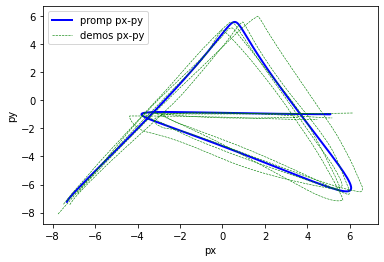

In [22]:
plt.plot(pred_pv[0], pred_pv[1], 'b', label='promp px-py', linewidth=2)
for i in range(demosNum):
   if i == 0:
       plt.plot(dataset[i][0], dataset[i][1], 'g--', linewidth=0.6, label='demos px-py')
   else:
       plt.plot(dataset[i][0], dataset[i][1], 'g--', linewidth=0.6)
plt.xlabel("px")
plt.ylabel("py")
plt.legend()
plt.show()

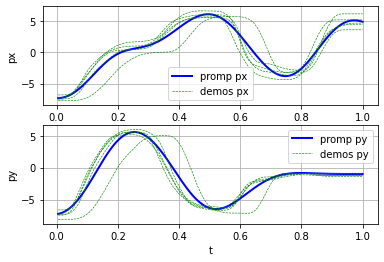

In [23]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t0, pred_pv[0], 'b', label='promp px', linewidth=2)
for i in range(demosNum):
    if i == 0:
        ax1.plot(t0, dataset[i][0], 'g--', linewidth=0.6, label='demos px')
    else:
        ax1.plot(t0, dataset[i][0], 'g--', linewidth=0.6)
ax1.set_ylabel("px")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t0, pred_pv[1], 'b', label='promp py', linewidth=2)
for i in range(demosNum):
    if i == 0:
        ax2.plot(t0, dataset[i][1], 'g--', linewidth=0.6, label='demos py')
    else:
        ax2.plot(t0, dataset[i][1], 'g--', linewidth=0.6)
ax2.set_ylabel("py")
ax2.set_xlabel("t")
plt.legend()
ax2.grid()
plt.show()

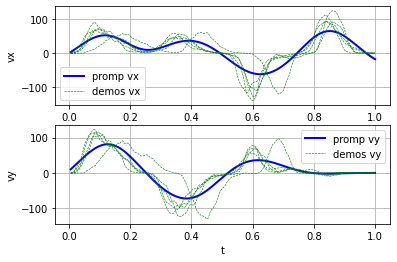

In [24]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t0, pred_pv[2], 'b', label='promp vx', linewidth=2)
for i in range(demosNum):
    if i == 0:
        ax1.plot(t0, dataset[i][2], 'g--', linewidth=0.6, label='demos vx')
    else:
        ax1.plot(t0, dataset[i][2], 'g--', linewidth=0.6)
ax1.set_ylabel("vx")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t0, pred_pv[3], 'b', label='promp vy', linewidth=2)
for i in range(demosNum):
    if i == 0:
        ax2.plot(t0, dataset[i][3], 'g--', linewidth=0.6, label='demos vy')
    else:
        ax2.plot(t0, dataset[i][3], 'g--', linewidth=0.6)
ax2.set_ylabel("vy")
ax2.set_xlabel("t")
plt.legend()
ax2.grid()
plt.show()